# **Project Introduction**

This notebook trains a deep learning model to classify brain CT scans into three categories: Bleeding, Ischemia, and Normal. The workflow follows a full supervised learning pipeline starting with dataset preparation, splitting the images into train/validation/test sets, and organizing them into a clean directory structure. The model is trained using transfer learning, fine-tuning the pretrained YOLOv8 classification architecture on the medical dataset. After training, the model is evaluated on held-out data to measure accuracy and overall performance. This notebook provides a complete, end-to-end process for building a medical image classifier using modern deep learning tools.

## Downloading Dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Setting up the Kaggle API key by creating the config folder, placing kaggle.json inside, and securing its permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#downloading dataset
!kaggle datasets download -d ozguraslank/brain-stroke-ct-dataset


Dataset URL: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset
License(s): other
 93% 1.31G/1.41G [00:08<00:02, 41.8MB/s]
100% 1.41G/1.41G [00:08<00:00, 178MB/s] 


In [ ]:
#unzipping datasets
!unzip brain-stroke-ct-dataset.zip -d data_raw


Streaming output truncated to the last 5000 lines.
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16125.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16127.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16128.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16129.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16130.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16132.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16134.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16135.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16136.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16138.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16141.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16144.dcm  
  inflating: data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM/16145.dcm  
  inflating: data_raw/Brai

In [ ]:
import os
os.listdir("data_raw")


['Brain_Stroke_CT_Dataset']

In [ ]:
os.listdir("data_raw/Brain_Stroke_CT_Dataset")


['Normal', 'External_Test', 'Ischemia', 'Bleeding']

# Data Preprocessing

In [ ]:
import os, shutil, random

# Source dataset, destination folder, class names, and split ratios
SRC = "data_raw/Brain_Stroke_CT_Dataset"
DEST = "data"
CLASSES = ["Bleeding", "Ischemia", "Normal"]
SPLITS = {"train": 0.7, "val": 0.15, "test": 0.15}

# Set seed for reproducible splits
random.seed(42)

# Create train/val/test folders for each class
for split in SPLITS:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls.lower()), exist_ok=True)

# Loop through classes and split images
for cls in CLASSES:
    src_dir = os.path.join(SRC, cls)

    # Collect image files for this class
    imgs = [f for f in os.listdir(src_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    random.shuffle(imgs)

    # Compute split indices
    n = len(imgs)
    a = int(SPLITS['train'] * n)
    b = a + int(SPLITS['val'] * n)

    # Slice into train/val/test sets
    parts = {"train": imgs[:a], "val": imgs[a:b], "test": imgs[b:]}

    # Copy images into destination folders
    for split, files_ in parts.items():
        for f in files_:
            shutil.copy(os.path.join(src_dir, f), os.path.join(DEST, split, cls.lower(), f))


print("Dataset is ready in 'data/'")


Dataset is ready in 'data/'


In [ ]:
!pip install ultralytics matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.9 MB/s eta 0:00:00


In [ ]:


for root, dirs, files in os.walk("data"):
    print(root, "->", len(files), "files")



data -> 0 files
data/train -> 0 files
data/train/ischemia -> 0 files
data/train/bleeding -> 0 files
data/train/normal -> 0 files
data/val -> 0 files
data/val/ischemia -> 0 files
data/val/bleeding -> 0 files
data/val/normal -> 0 files
data/test -> 0 files
data/test/ischemia -> 0 files
data/test/bleeding -> 0 files
data/test/normal -> 0 files


In [ ]:


for folder in ["Bleeding", "Ischemia", "Normal"]:
    path = f"data_raw/Brain_Stroke_CT_Dataset/{folder}"
    print(folder, "->", len(os.listdir(path)), "files")


Bleeding -> 3 files
Ischemia -> 3 files
Normal -> 2 files


In [ ]:


for folder in ["Bleeding", "Ischemia", "Normal"]:
    print(f"\n--- {folder} ---")
    for root, dirs, files in os.walk(f"data_raw/Brain_Stroke_CT_Dataset/{folder}"):
        print(root, "->", len(files), "files")



--- Bleeding ---
data_raw/Brain_Stroke_CT_Dataset/Bleeding -> 0 files
data_raw/Brain_Stroke_CT_Dataset/Bleeding/OVERLAY -> 1093 files
data_raw/Brain_Stroke_CT_Dataset/Bleeding/PNG -> 1093 files
data_raw/Brain_Stroke_CT_Dataset/Bleeding/DICOM -> 1093 files

--- Ischemia ---
data_raw/Brain_Stroke_CT_Dataset/Ischemia -> 0 files
data_raw/Brain_Stroke_CT_Dataset/Ischemia/OVERLAY -> 1130 files
data_raw/Brain_Stroke_CT_Dataset/Ischemia/PNG -> 1130 files
data_raw/Brain_Stroke_CT_Dataset/Ischemia/DICOM -> 1130 files

--- Normal ---
data_raw/Brain_Stroke_CT_Dataset/Normal -> 0 files
data_raw/Brain_Stroke_CT_Dataset/Normal/PNG -> 4427 files
data_raw/Brain_Stroke_CT_Dataset/Normal/DICOM -> 4427 files


In [ ]:


# Setting the dataset paths, class names, and split ratios
SRC = "data_raw/Brain_Stroke_CT_Dataset"
DEST = "data"
CLASSES = ["Bleeding", "Ischemia", "Normal"]
SPLITS = {"train": 0.7, "val": 0.15, "test": 0.15}

# Clearing out any old dataset folder so the rebuild starts clean
if os.path.exists(DEST):
    shutil.rmtree(DEST)

# Keeping the randomness consistent for the same split results every time
random.seed(42)

# Creating the train/val/test folder structure for each class
for split in SPLITS:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls.lower()), exist_ok=True)

# Function that gathers all PNG/JPG images from a folder and its subfolders
def get_png_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(root, f))
    return imgs

# Going through each class and building the dataset splits
for cls in CLASSES:

    # Pointing to the PNG folder inside each class directory
    src_dir = os.path.join(SRC, cls, "PNG")

    # Collecting all valid image files for the class
    imgs = get_png_images(src_dir)

    # Shuffling the list to randomize the dataset
    random.shuffle(imgs)

    # Computing how many images belong in each split
    n = len(imgs)
    a = int(SPLITS["train"] * n)
    b = a + int(SPLITS["val"] * n)

    # Dividing the images into train, val, and test groups
    parts = {"train": imgs[:a], "val": imgs[a:b], "test": imgs[b:]}

    # Copying each image into its split/class folder
    for split, files_ in parts.items():
        for f in files_:
            shutil.copy(f, os.path.join(DEST, split, cls.lower()))

# Final message confirming the dataset rebuild
print("Dataset rebuilt using PNG folders only")


Dataset rebuilt using PNG folders only


**Training YOLOv8 clasification Model**

In [ ]:
!yolo \
  task=classify \
  mode=train \
  model=yolov8n-cls.pt \
  data="data" \
  epochs=20 \
  imgsz=224


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_wid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/train2/weights/


best.pt  last.pt


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/train2/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving IM_0014-ID_b7cc0c647.png to IM_0014-ID_b7cc0c647.png
Saving IM_0002-ID_1b9de2922.png to IM_0002-ID_1b9de2922.png


In [ ]:
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/train2/weights/best.pt")
model.predict(list(uploaded.keys()))



0: 224x224 bleeding 0.84, ischemia 0.16, normal 0.00, 15.5ms
1: 224x224 normal 0.37, ischemia 0.35, bleeding 0.28, 15.5ms
Speed: 9.6ms preprocess, 15.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 masks: None
 names: {0: 'bleeding', 1: 'ischemia', 2: 'normal'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
        

In [ ]:
model.val()

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/data/train... found 4654 images in 3 classes ✅ 
val: /content/data/val... found 996 images in 3 classes ✅ 
test: /content/data/test... found 1000 images in 3 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1263.4±383.9 MB/s, size: 83.1 KB)
val: Scanning /content/data/val... 996 images, 0 corrupt: 100% ━━━━━━━━━━━━ 996/996 1.1Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 63/63 10.1it/s 6.2s
                   all      0.952          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3167e69a00>
curves: []
curves_results: []
fitness: 0.9759036004543304
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9518072009086609, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9759036004543304}
save_dir: PosixPath('/content/runs/classify/val2')
speed: {'preprocess': 0.09269546084320303, 'inference': 0.7675735391580106, 'loss': 0.0008810271071477283, 'postprocess': 0.0013142560229575484}
task: 'classify'
top1: 0.9518072009086609
top5: 1.0

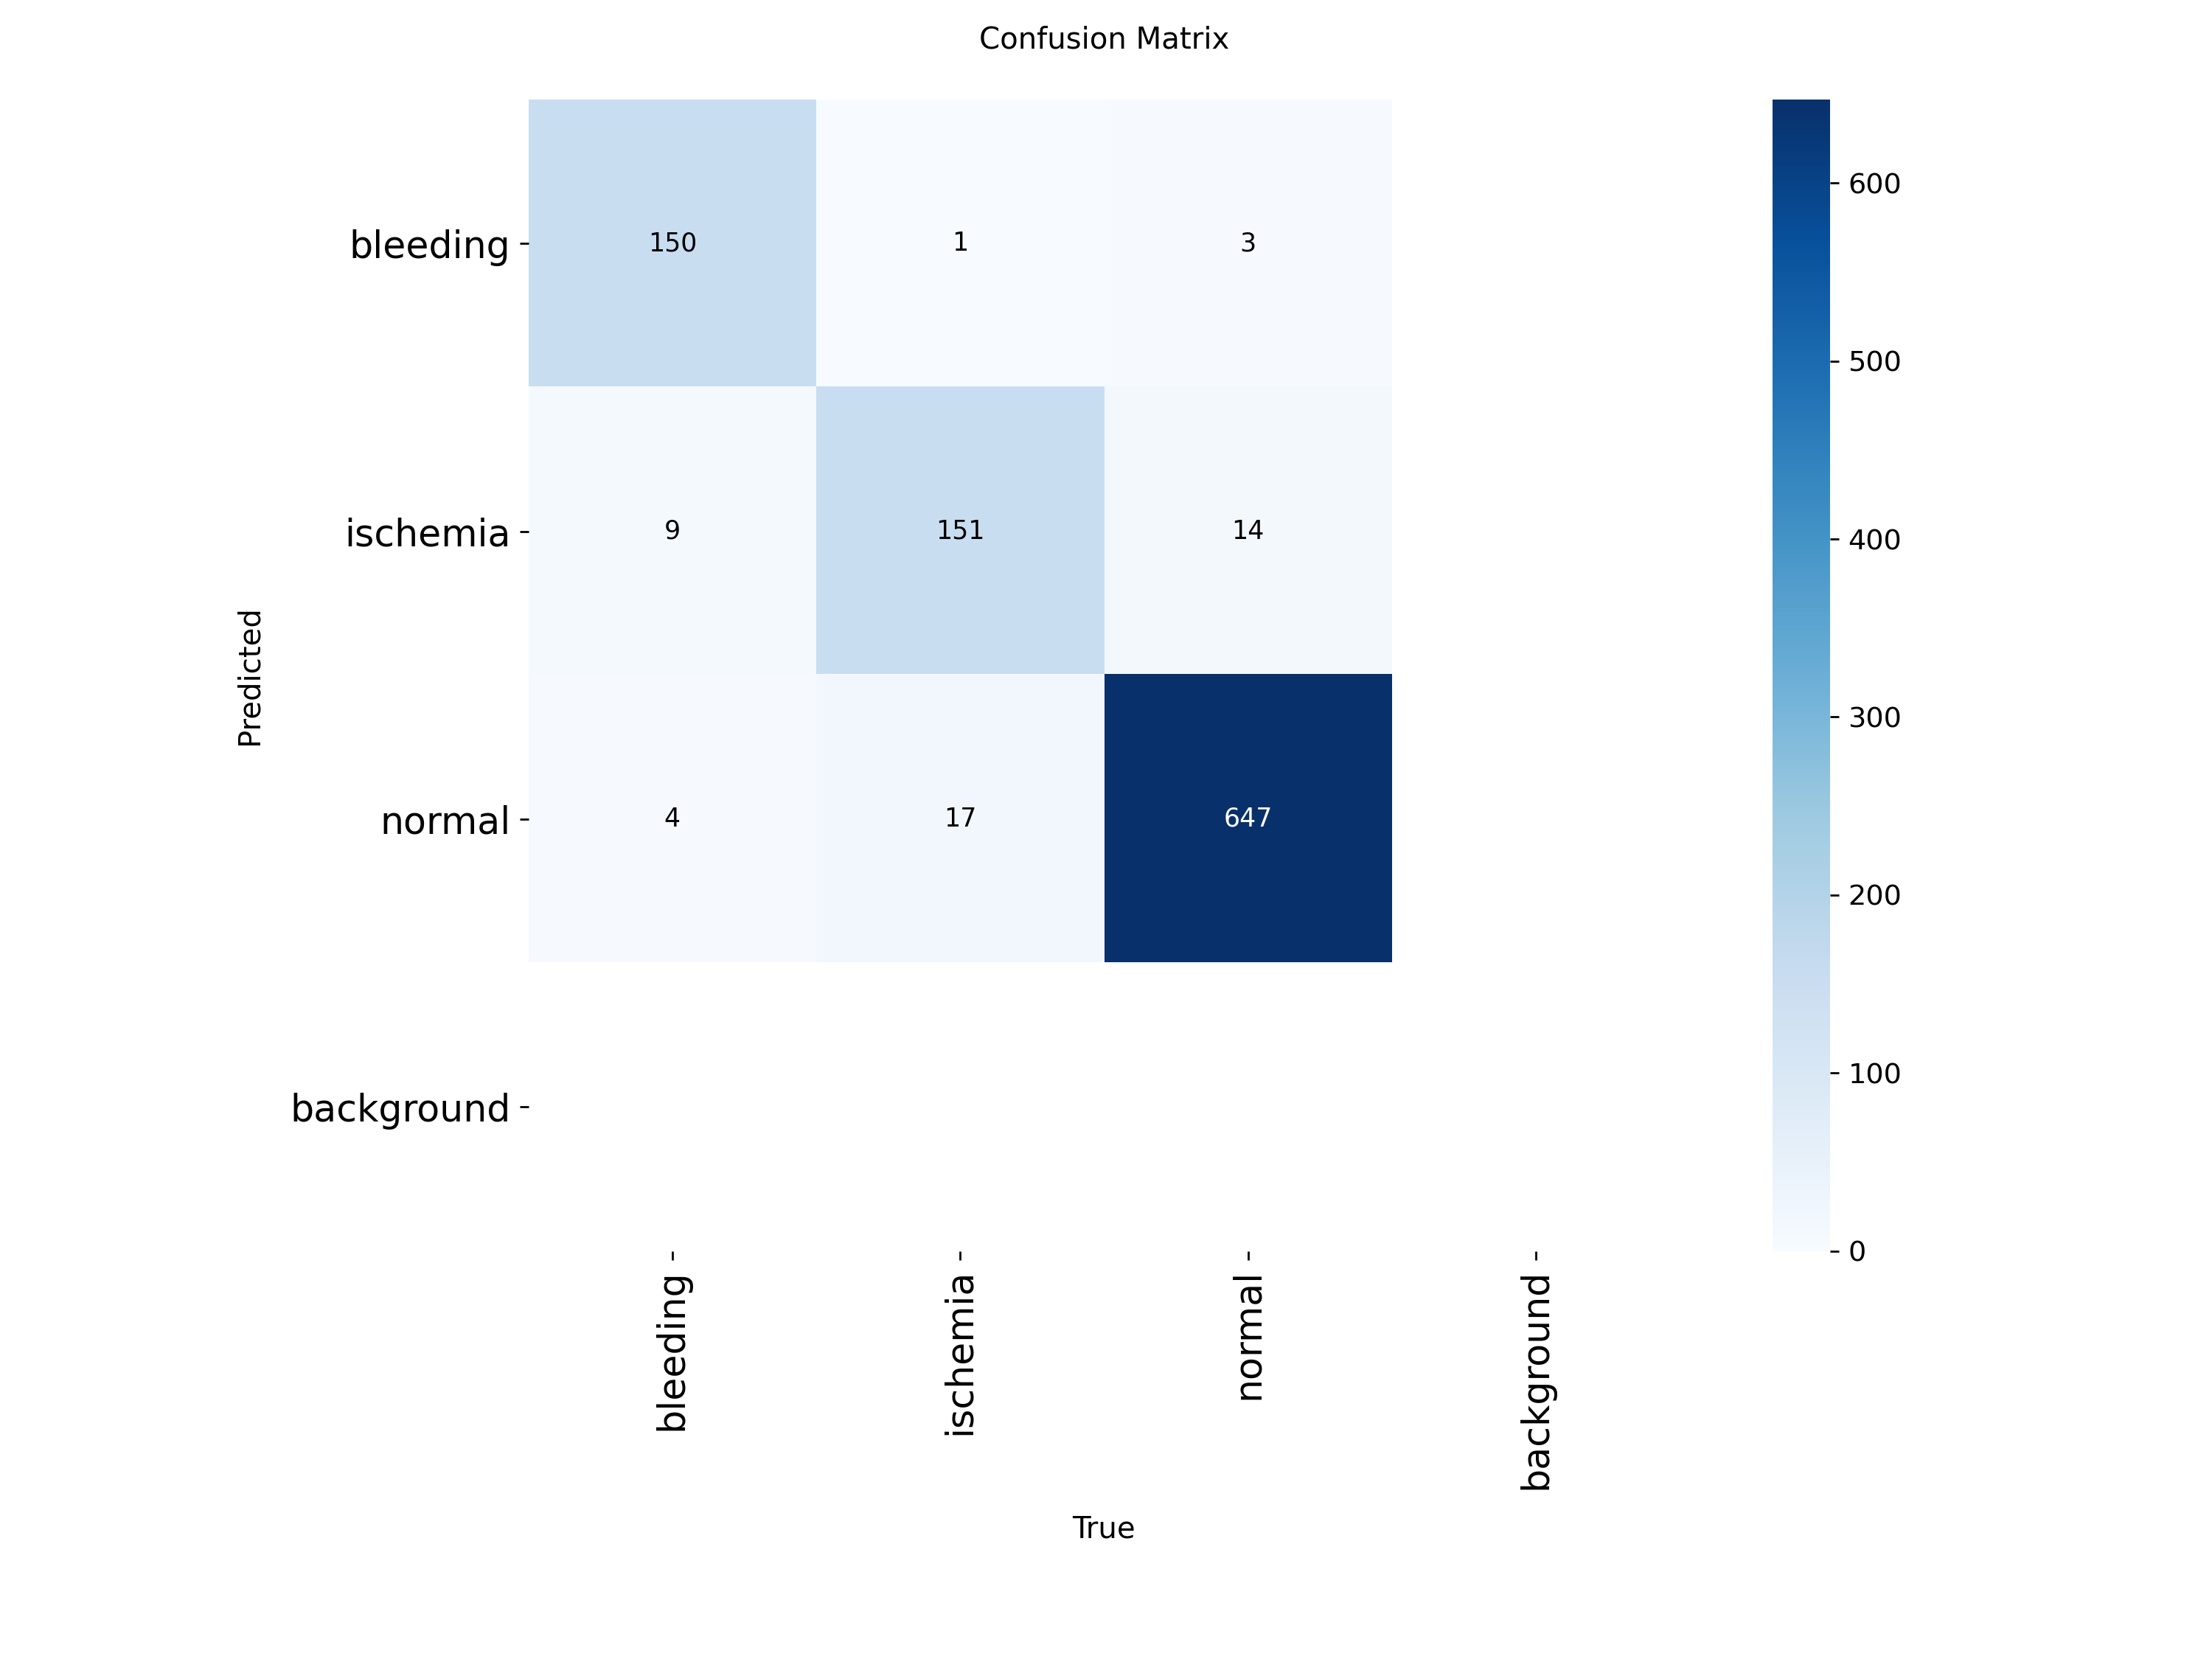

In [ ]:
from IPython.display import Image
Image("/content/runs/classify/val2/confusion_matrix.png")
